In [1]:
import pickle

class BasicTokenizer():

    def __init__(self , data_path : str = None , vocab_size : int = None , verbose:bool = False):
        self.data_path = data_path
        self.vocab_size = vocab_size
        self.verbose = verbose
        self.merges = {}
        self.vocab = {}


    def load_text(self):
        with open(self.data_path, 'r', encoding='utf-8') as f:
            text = f.read()

        return text


    @staticmethod
    def get_stats(ids):
        counts = {}
        for pair in zip(ids, ids[1:]):
            counts[pair] = counts.get(pair, 0) + 1

        return counts


    @staticmethod
    def merge(ids, pair, idx):
        newids = []
        i = 0
        while i < len(ids):
            if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
                newids.append(idx)
                i += 2
            else:
                newids.append(ids[i])
                i += 1

        return newids


    def train(self):
        assert self.vocab_size >= 256
        assert self.data_path is not None
        text = self.load_text()
        num_merges = self.vocab_size - 256
        text_bytes = text.encode("utf-8")
        ids = list(text_bytes)
        self.vocab = {idx: bytes([idx]) for idx in range(256)}
        for i in range(num_merges):
            stats = self.get_stats(ids)
            pair = max(stats, key=stats.get)
            idx = 256 + i
            ids = self.merge(ids, pair, idx)
            self.merges[pair] = idx
            self.vocab[idx] = self.vocab[pair[0]] + self.vocab[pair[1]]
            if self.verbose:
                print(f"merge {i+1}/{num_merges}: {pair} -> {idx} ({self.vocab[idx]}) had {stats[pair]} occurrences")
        print(f"compression ratio: {len(text_bytes) / len(ids):.2f}X")
        with open("merges.pkl" , "wb") as merge_file:
            pickle.dump(self.merges , merge_file)
        with open ("vocab.pkl" , "wb") as vf:
            pickle.dump(self.vocab , vf)


    def encode(self , text_to_encode):
        with open("merges.pkl" , "rb") as mf:
            merges = pickle.load(mf)
        text_bytes = text_to_encode.encode("utf-8")
        ids = list(text_bytes)
        while len(ids) >= 2:
            stats = self.get_stats(ids)
            pair = min(stats, key=lambda p: merges.get(p, float("inf")))
            if pair not in merges:
                break
            idx = merges[pair]
            ids = self.merge(ids, pair, idx)
        print(f"compression ratio: {len(text_bytes) / len(ids):.2f}X")

        return ids


    def decode(self , ids):
        with open("vocab.pkl" , "rb") as vf:
            vocab = pickle.load(vf)
        text_bytes = b"".join(vocab[idx] for idx in ids)
        text = text_bytes.decode("utf-8", errors="replace")

        return text

In [2]:
tokenize = BasicTokenizer(data_path="/content/input.txt" , vocab_size=500 , verbose = True)

In [4]:
tokenize.train()

merge 1/244: (101, 32) -> 256 (b'e ') had 27643 occurrences
merge 2/244: (116, 104) -> 257 (b'th') had 22739 occurrences
merge 3/244: (116, 32) -> 258 (b't ') had 16508 occurrences
merge 4/244: (115, 32) -> 259 (b's ') had 15364 occurrences
merge 5/244: (100, 32) -> 260 (b'd ') had 14165 occurrences
merge 6/244: (44, 32) -> 261 (b', ') had 14098 occurrences
merge 7/244: (111, 117) -> 262 (b'ou') had 12730 occurrences
merge 8/244: (101, 114) -> 263 (b'er') had 11771 occurrences
merge 9/244: (105, 110) -> 264 (b'in') had 10606 occurrences
merge 10/244: (121, 32) -> 265 (b'y ') had 10283 occurrences
merge 11/244: (97, 110) -> 266 (b'an') had 10197 occurrences
merge 12/244: (58, 10) -> 267 (b':\n') had 8762 occurrences
merge 13/244: (111, 114) -> 268 (b'or') had 8458 occurrences
merge 14/244: (111, 32) -> 269 (b'o ') had 8134 occurrences
merge 15/244: (101, 110) -> 270 (b'en') had 7568 occurrences
merge 16/244: (10, 10) -> 271 (b'\n\n') had 7098 occurrences
merge 17/244: (97, 114) -> 272 (

The device is cuda
compression ratio: 1.94X
3.514836 M parameters
step 0: train loss 6.3745, val loss 6.3751
step 500: train loss 3.5464, val loss 3.7969
step 1000: train loss 3.0977, val loss 3.4748
step 1500: train loss 2.7643, val loss 3.2111
step 2000: train loss 2.5888, val loss 3.0921
step 2500: train loss 2.4640, val loss 3.0266
step 3000: train loss 2.3691, val loss 2.9763
step 3500: train loss 2.2935, val loss 2.9540
step 4000: train loss 2.2224, val loss 2.9450
step 4500: train loss 2.1560, val loss 2.9428
step 4999: train loss 2.0976, val loss 2.9551
Time taken to generate 10K tokens with the unquantised model is 2.9626462936401365


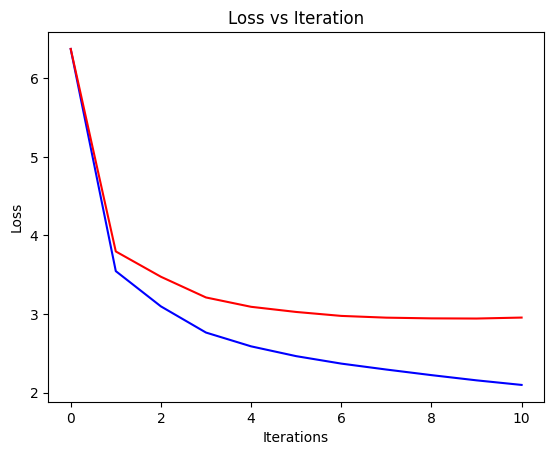

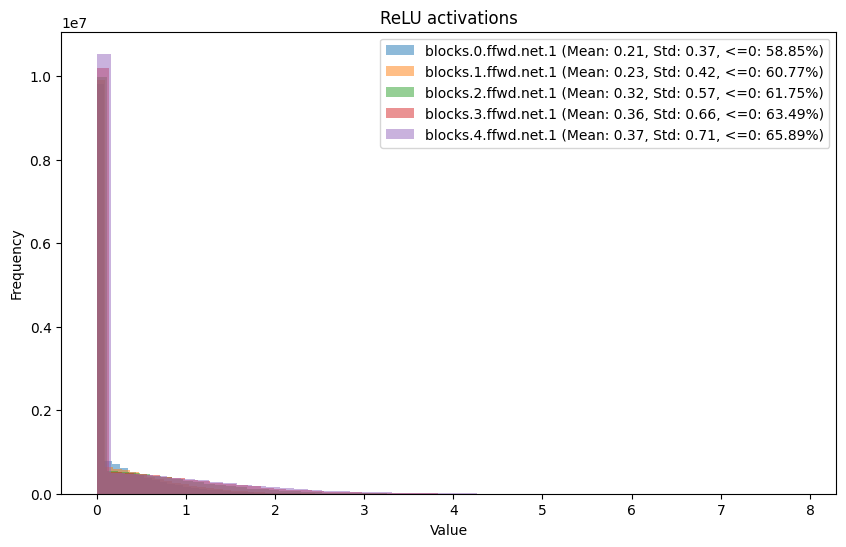

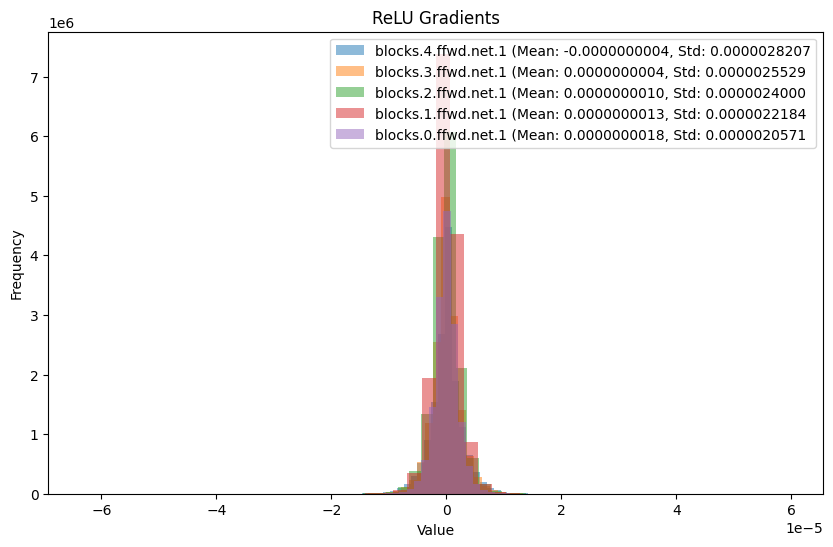

In [6]:
# PyTorch imports
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import time

# hyperparameters
batch_size = 64
block_size = 256
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"The device is {device}")
eval_iters = 200
n_embd = 232
n_head = 6
n_layer = 5
dropout = 0.2
vocab_size = 500

# Opening the data
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Train and test splits
data = torch.tensor(tokenize.encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y with random off sets
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    # Calculate the loss every 500 iters avaraging it over last 200 iters
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# Calculate the model size
def get_model_size(model):
    param_size = 0
    buffer_size = 0
    for param in model.parameters():
        param_size += param.numel() * param.element_size()
    for buffer in model.buffers():
        buffer_size += buffer.numel() * buffer.element_size()
    total_size = param_size + buffer_size
    return total_size

class Head(nn.Module):
    # One head of Self Attention
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x --> (B , T , hs)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size) # communication
        self.ffwd = FeedFoward(n_embd) # Calculation
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class Decoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C) -> Broadcasting
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx (B , T)
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:] # cropping context
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] # (B, C)
            probs = F.softmax(logits, dim=-1) # (B, C)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = Decoder()
model = model.to(device)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# Getting the activations and gradients of ReLU for plotting
relu_outputs = {}
relu_gradients = {}
def forward_hook(name):
    def hook(module, input, output):
        relu_outputs[name] = output.detach()
    return hook
def backward_hook(name):
    def hook(module, grad_input, grad_output):
        relu_gradients[name] = grad_output[0].detach()
    return hook
def get_relu_stats():
    for name, module in model.named_modules():
        if isinstance(module, nn.ReLU):
            module.register_forward_hook(forward_hook(name))
            module.register_backward_hook(backward_hook(name))
get_relu_stats()

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

loss_t = []
loss_v = []
for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        loss_t.append(losses["train"])
        loss_v.append(losses["val"])
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Plotting the loss
training_loss = [tensor.item() for tensor in loss_t]
val_loss = [tensor.item() for tensor in loss_v]
plt.plot(training_loss, color='blue', label='Training Loss')
plt.plot(val_loss, color='red', label='Validation Loss')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iteration')
plt.savefig("Loss Plot")
# plt.show()


# Plotting the ReLU activations
plt.figure(figsize=(10, 6))
for key, tensor in relu_outputs.items():
    flattened_tensor = tensor.flatten()
    mean = flattened_tensor.mean().item()
    std = flattened_tensor.std().item()
    percentage_le_zero = (flattened_tensor <= 0.0).sum().item() / flattened_tensor.numel() * 100
    # print(f'{key}: Mean = {mean:.2f}, Std = {std:.2f}, Percentage <= 0.0 = {percentage_le_zero:.2f}%')
    plt.hist(flattened_tensor.cpu().numpy(), bins=50, alpha=0.5, label=f'{key} (Mean: {mean:.2f}, Std: {std:.2f}, <=0: {percentage_le_zero:.2f}%)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('ReLU activations')
plt.legend()
plt.savefig("ReLU Activations")
# plt.show()

# Plotting the ReLU gradients
plt.figure(figsize=(10, 6))
for key, tensor in relu_gradients.items():
    flattened_tensor = tensor.flatten()
    mean = flattened_tensor.mean().item()
    std = flattened_tensor.std().item()
    # print(f'{key}: Mean = {mean:.2f}, Std = {std:.2f}')
    plt.hist(flattened_tensor.cpu().numpy(), bins=50, alpha=0.5, label=f'{key} (Mean: {mean:.10f}, Std: {std:.10f}')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('ReLU Gradients')
plt.legend()
plt.savefig("ReLU gradients")
# plt.show()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
start = time.time()
# print(tokenize.decode(model.generate(context, max_new_tokens=10000)[0].tolist()))
open('output.txt', 'w').write(tokenize.decode(model.generate(context, max_new_tokens=10000)[0].tolist()))
end = time.time()
print(f"Time taken to generate 10K tokens with the unquantised model is {(end-start)/60}")
time_nq = (end-start)/60

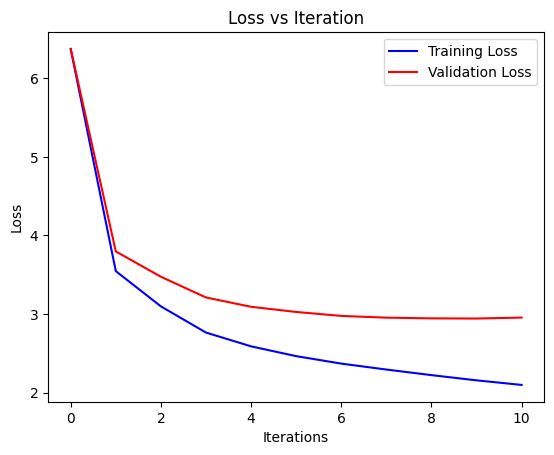

In [7]:
# Plotting the loss with legends
training_loss = [tensor.item() for tensor in loss_t]
val_loss = [tensor.item() for tensor in loss_v]
plt.plot(training_loss, color='blue', label='Training Loss')
plt.plot(val_loss, color='red', label='Validation Loss')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iteration')
plt.savefig("Loss Plot 2")
plt.show()

In [12]:
print(tokenize.decode(model.generate(context, max_new_tokens=250)[0].tolist()))

 um as your utmocks! why?
What inher! say, even-like her hoose:
O, the issued his Capule?
Or misue that was heavens! weep mold of death,
For suspicing hath been envictious tease;
In all yield my fear in scourt? Alas, my father,
Is sword, with a lawfter'd, face.

A queen?

FLORIZEL:
Ay, consolemen:
I beseem thy grought your made havise;
Please in this maoth father keeper's vows,
And I am afflicious vein
To sail out a life of a tith rich thoughts,
And those 


In [10]:
state_dict_w = model.state_dict()
torch.save(state_dict_w , "model_weight_uq.pth")

In [13]:

class Int8LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, dtype=torch.float32):
        # Dummy attributes, to be changed later
        super().__init__()
        self.register_buffer("int8_weights",torch.randint(-128, 127, (out_features, in_features), dtype=torch.int8))
        self.register_buffer("scales", torch.randn((out_features), dtype=dtype))
        if bias:
            self.register_buffer("bias", torch.randn((1, out_features), dtype=dtype))
        else:
            self.bias = None

    @staticmethod
    def w8_forward(weight, input, scales, bias=None):
        # forward pass through the quantised layer
        casted_weights = weight.to(input.dtype) # dequantise the weights for forward pass
        output = F.linear(input, casted_weights) * scales # forward , weights already in original dtype
        if bias is not None:
            output = output + bias
        return output

    def quantize(self, weights):
        # Quantise the layers weight in int 8 , and keep the scales to dequantise during forward pass
        w_fp32 = weights.clone().to(torch.float32) # copy of the weights
        scales = w_fp32.abs().max(dim=-1).values / 127 # scale for quantisation
        scales = scales.to(weights.dtype) # scales in original data type
        int8_weights = torch.round(weights/scales.unsqueeze(-1)).to(torch.int8) # weights in int8
        self.int8_weights = int8_weights # int8
        self.scales = scales # original dtype

    def forward(self, input):
        return self.w8_forward(self.int8_weights, input, self.scales, self.bias)

def replace_linear_layer(module, target_class, module_name_to_exclude):
    for name, child in module.named_children():
        if isinstance(child, nn.Linear) and not \
        any([x == name for x in module_name_to_exclude]):
            old_bias = child.bias
            old_weight = child.weight
            new_module = target_class(child.in_features, child.out_features, old_bias is not None, child.weight.dtype)
            setattr(module, name, new_module)
            getattr(module, name).quantize(old_weight)
            if old_bias is not None:
              getattr(module, name).bias = old_bias
        else:
            # Recursively call the function for nested modules
            replace_linear_layer(child, target_class, module_name_to_exclude)


# print(model)
model_size = get_model_size(model)
print(f"Model size before quantisation: {model_size / 1e6:.2f} MB")
replace_linear_layer(model, Int8LinearLayer, ["lm_head"]) # not quantising the final layer
model.to(device) # move the quantised the model to cuda , if available
# print(model)
model_size_q = get_model_size(model)
print(f"Model size after quantisation: {model_size_q / 1e6:.2f} MB")
print(f"Model has shrinked by {(model_size/model_size_q):.2f}X")


Model size before quantisation: 21.92 MB
Model size after quantisation: 12.33 MB
Model has shrinked by 1.78X
Time taken to generate 10,000 tokens with the quantised model is 4.023098520437876
Inference Time has reduced by 0.74X


In [16]:
print(model)

Decoder(
  (token_embedding_table): Embedding(500, 232)
  (position_embedding_table): Embedding(256, 232)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (key): Int8LinearLayer()
            (query): Int8LinearLayer()
            (value): Int8LinearLayer()
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Int8LinearLayer()
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Int8LinearLayer()
          (1): ReLU()
          (2): Int8LinearLayer()
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((232,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((232,), eps=1e-05, elementwise_affine=True)
    )
    (1): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (key): Int8LinearLayer()


In [14]:
state_dict_w = model.state_dict()
torch.save(state_dict_w , "model_weight_q.pth")

In [18]:
print(tokenize.decode(model.generate(context, max_new_tokens=250)[0].tolist()))

 , if to die.

FLORIZEL:
Well, wifed, that you thou roung not
At lady's death A mety notior.

LEONTES:
Do you are here? He a fool! here shall be merry had
To meet you, goldly he shall
Upon the uncerJove him a well-wish on
What feal that further wish'd! thou hast so't
Statel'st thou but we shall bittance evil.

First Lady:
Myrantly poor;
If I mighty my noblewd worthumble we is a duke.

ROMEO:
The royal, and thereof the Ear,
Slew thou mayst not thy lap in cardy m
